In [1]:
%pip install -q hvplot
# Install memory_profiler 
%pip install memory_profiler
%pip install imbalanced-learn

# Load memory_profiler extension
%load_ext memory_profiler

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import hvplot.pandas
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE



import time

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)


### Introduction
- LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.
- What we are trying to do is to predict the loan approval of a person based on the data we have been given
- Lets now **load** the data and **describe** it.

In [3]:
data = pd.read_csv("train_lending_club.csv")
print("Data imported successfully")
test_data = pd.read_csv("test_lending_club.csv")
print(data.head())
print("Test data imported successfully")
print(test_data.head())

Data imported successfully
      issue_d sub_grade        term home_ownership  fico_range_low  total_acc  \
0  2014-01-01        D1   60 months       MORTGAGE          660.00      18.00   
1  2014-01-01        C4   60 months       MORTGAGE          740.00      26.00   
2  2014-01-01        A4   36 months           RENT          700.00      47.00   
3  2014-01-01        D1   60 months       MORTGAGE          665.00      26.00   
4  2014-01-01        C3   36 months       MORTGAGE          700.00      15.00   

   pub_rec  revol_util  annual_inc  int_rate   dti             purpose  \
0     0.00       86.80    40440.00     16.99 15.16         credit_card   
1     0.00      103.50    59000.00     15.61 16.74         credit_card   
2     0.00       11.40    40000.00      7.90 20.34  debt_consolidation   
3     0.00       56.20    70000.00     16.99 23.15  debt_consolidation   
4     1.00       67.10   120000.00     14.98 17.88            vacation   

   mort_acc  loan_amnt application_type  

### Description of the data



In [4]:
data.describe()

,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,dti,mort_acc,loan_amnt,installment,pub_rec_bankruptcies,fico_range_high,revol_bal,id,open_acc,emp_length,loan_status,time_to_earliest_cr_line
count,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00
mean,694.35,25.57,0.24,52.85,77379.53,12.60,18.53,1.73,14626.43,441.92,0.14,698.35,16956.26,49269391.36,11.81,5.99,0.83,526420.51
std,30.93,12.20,0.67,24.01,77290.67,4.48,9.21,2.04,8611.59,257.21,0.39,30.93,23829.01,20980382.07,5.59,4.24,0.37,241312.11
min,660.00,2.00,0.00,0.00,0.00,5.32,0.00,0.00,1000.00,14.77,0.00,664.00,0.00,56705.00,0.00,0.00,0.00,97113.60
25%,670.00,17.00,0.00,35.00,46000.00,9.17,12.05,0.00,8000.00,254.07,0.00,674.00,6127.00,33191497.25,8.00,2.00,1.00,360374.40
50%,685.00,24.00,0.00,53.00,65000.00,12.29,17.89,1.00,12450.00,378.20,0.00,689.00,11399.00,52979215.50,11.00,6.00,1.00,478483.20
75%,710.00,32.00,0.00,71.20,92000.00,15.31,24.52,3.00,20000.00,588.37,0.00,714.00,20431.00,66645529.25,15.00,11.00,1.00,647049.60
max,845.00,169.00,86.00,182.80,9573072.00,30.99,999.00,47.00,40000.00,1534.88,9.00,850.00,2560703.00,84363456.00,76.00,11.00,1.00,2240524.80


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236846 entries, 0 to 236845
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   issue_d                   236846 non-null  object 
 1   sub_grade                 236846 non-null  object 
 2   term                      236846 non-null  object 
 3   home_ownership            236846 non-null  object 
 4   fico_range_low            236846 non-null  float64
 5   total_acc                 236846 non-null  float64
 6   pub_rec                   236846 non-null  float64
 7   revol_util                236846 non-null  float64
 8   annual_inc                236846 non-null  float64
 9   int_rate                  236846 non-null  float64
 10  dti                       236846 non-null  float64
 11  purpose                   236846 non-null  object 
 12  mort_acc                  236846 non-null  float64
 13  loan_amnt                 236846 non-null  f

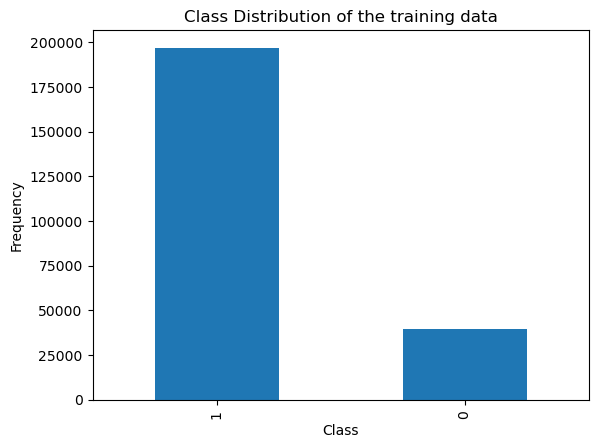

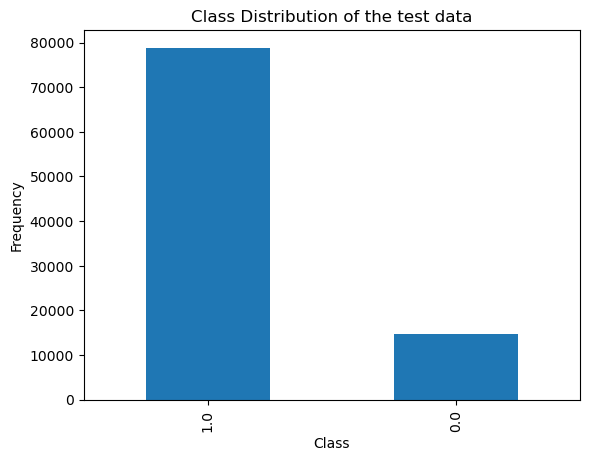

In [6]:
import matplotlib.pyplot as plt
data['loan_status'].value_counts().plot(kind='bar')
plt.title('Class Distribution of the training data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


test_data['loan_status'].value_counts().plot(kind='bar')
plt.title('Class Distribution of the test data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


## Data Preprocessing
- Remove or fill any missing data
- scaling
- convert categorical data into numeric 

In [7]:
print(f"The Length of the data: {data.shape}")


The Length of the data: (236846, 27)


In [8]:
for dataset in [data, test_data]:
    for column in dataset.columns:
        if dataset[column].isna().sum() != 0:
            missing = dataset[column].isna().sum()
            portion = (missing / dataset.shape[0]) * 100
            print(f"'{column}' in {'training' if dataset is data else 'test'} dataset: number of missing values '{missing}' ==> '{portion:.3f}%'")



'home_ownership' in test dataset: number of missing values '826' ==> '0.869%'
'loan_status' in test dataset: number of missing values '1412' ==> '1.486%'


In [9]:
# Since only the test set contains missing values, we will fill the missing values 
# Separate numerical and categorical columns
numerical_cols = test_data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = test_data.select_dtypes(include=['object', 'category']).columns

# Impute numerical columns with the median
num_imputer = SimpleImputer(strategy='median')
test_data[numerical_cols] = num_imputer.fit_transform(test_data[numerical_cols])

# Impute categorical columns with the most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
test_data[categorical_cols] = cat_imputer.fit_transform(test_data[categorical_cols])

# Check if there are any missing values left
print(test_data.isna().sum())

issue_d                     0
sub_grade                   0
term                        0
home_ownership              0
fico_range_low              0
total_acc                   0
pub_rec                     0
revol_util                  0
annual_inc                  0
int_rate                    0
dti                         0
purpose                     0
mort_acc                    0
loan_amnt                   0
application_type            0
installment                 0
verification_status         0
pub_rec_bankruptcies        0
addr_state                  0
initial_list_status         0
fico_range_high             0
revol_bal                   0
id                          0
open_acc                    0
emp_length                  0
loan_status                 0
time_to_earliest_cr_line    0
dtype: int64


### Label Encoding
- Turning Categorical values into numerical 

In [10]:
# List of categorical columns to convert
categorical_columns = ['sub_grade', 'term', 'home_ownership', 'purpose', 'application_type', 'verification_status', 'initial_list_status']

# One-hot encode these columns
data = pd.get_dummies(data, columns=categorical_columns)
test_data = pd.get_dummies(test_data, columns=categorical_columns)

# Ensure that both dataframes have the same dummy columns
data, test_data = data.align(test_data, join='left', axis=1, fill_value=0)

print(f"Length of the training data: {data.shape}")
print(f"Length of the test data: {test_data.shape}")

Length of the training data: (236846, 81)
Length of the test data: (95019, 81)


In [11]:
# remove issue date because before hand we don't know when the loan will be issued
# drop loan_status because it is the target
# drop id,addr_state because it is not useful


# Store 'loan_status' in a separate variable and then drop non-feature columns from the training data
y_train = data['loan_status']
X_train = data.drop(['issue_d', 'loan_status', 'id', 'addr_state'], axis=1)

# Assume 'loan_status' is also a column in your test_data that you want to predict
# If 'loan_status' is not in your test_data, you would not have this line and y_test would not be defined here
y_test = test_data['loan_status']
X_test = test_data.drop(['issue_d', 'loan_status', 'id', 'addr_state'], axis=1)

print(X_train.head())
print(f"Length of the training features: {X_train.shape}")
print(X_test.head())
print(f"Length of the test features: {X_test.shape}")



   fico_range_low  total_acc  pub_rec  revol_util  annual_inc  int_rate   dti  \
0          660.00      18.00     0.00       86.80    40440.00     16.99 15.16   
1          740.00      26.00     0.00      103.50    59000.00     15.61 16.74   
2          700.00      47.00     0.00       11.40    40000.00      7.90 20.34   
3          665.00      26.00     0.00       56.20    70000.00     16.99 23.15   
4          700.00      15.00     1.00       67.10   120000.00     14.98 17.88   

   mort_acc  loan_amnt  installment  pub_rec_bankruptcies  fico_range_high  \
0      1.00   17775.00       441.66                  0.00           664.00   
1      4.00   29175.00       703.45                  0.00           744.00   
2      1.00    6000.00       187.75                  0.00           704.00   
3      7.00   15600.00       387.62                  0.00           669.00   
4      1.00   10000.00       346.56                  0.00           704.00   

   revol_bal  open_acc  emp_length  time_to_

In [12]:
#since there is an large sample size, we can use the SMOTE technique to balance the data
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Use 'minority' to only upsample the minority class

# Fit SMOTE on Training Data
X_train, y_train= smote.fit_resample(X_train, y_train)
# Fit SMOTE on Testing Data
X_test, y_test = smote.fit_resample(X_test, y_test)

### Logistic Regression


In [13]:
# Scale the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [14]:
logistic_classifier = LogisticRegression(max_iter=1000) # You can adjust regularization parameters if needed
logistic_classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

### KNN CLASSIFIER

In [15]:
# Train KNN Classifier
# in terminal set LOKY_MAX_CPU_COUNT= <number of cores you want to use>

knn_classifier = KNeighborsClassifier(n_neighbors=5) # You can adjust the number of neighbors (k) as needed
knn_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

### Performance evaluation Milestone 1

In [16]:
# F1 Score for Logistic Regression
logistic_f1_scores = cross_val_score(logistic_classifier, X_train_scaled, y_train, cv=5, scoring='f1')
print("Logistic Regression CV F1 Score:", logistic_f1_scores.mean())

# AUC for Logistic Regression
logistic_auc_scores = cross_val_score(logistic_classifier, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression CV ROC_AUC:", logistic_auc_scores.mean())

# Repeat for KNN
knn_f1_scores = cross_val_score(knn_classifier, X_train_scaled, y_train, cv=5, scoring='f1')
print("KNN CV F1 Score:", knn_f1_scores.mean())

knn_auc_scores = cross_val_score(knn_classifier, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("KNN CV ROC_
      
      AUC:", knn_auc_scores.mean())

Logistic Regression CV F1 Score: 0.9078886560234274
Logistic Regression CV ROC_AUC: 0.9369081350044153
KNN CV F1 Score: 0.8878969475871381
KNN CV ROC_AUC: 0.905591664497293


In [17]:
def plot_cv_roc_curve(classifier, X, y, cv_splits=5, classifier_name='Classifier'):
    """
    Plots ROC curves for each fold in cross-validation and the mean ROC curve.
    
    Parameters:
    - classifier: The classifier to use.
    - X: Feature set.
    - y: Target variable.
    - cv_splits: Number of cross-validation splits.
    - classifier_name: Name of the classifier (for legend labeling).
    """
    cv = StratifiedKFold(n_splits=cv_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        probas_ = classifier.predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} {classifier_name} (AUC = {roc_auc:.2f})')
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean {classifier_name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f"Receiver Operating Characteristic - {classifier_name}")
    ax.legend(loc="lower right")
    plt.show()


In [18]:
# Measure CPU time for training KNN Classifier
start_time = time.time()
knn_classifier.fit(X_train_scaled, y_train)
end_time = time.time()
print("Time taken for training KNN Classifier:", end_time - start_time, "seconds")

# Measure memory usage for training KNN Classifier
%memit knn_classifier.fit(X_train_scaled, y_train)


# Measure CPU time for training Logistic Regression Classifier
start_time = time.time()
logistic_classifier.fit(X_train_scaled, y_train)
end_time = time.time()
print("Time taken for training Logistic Classifier:", end_time - start_time, "seconds")

# Measure memory usage for training KNN Classifier
%memit logistic_classifier.fit(X_train_scaled, y_train)

Time taken for training KNN Classifier: 0.15752482414245605 seconds
peak memory: 1165.45 MiB, increment: 239.80 MiB
Time taken for training Logistic Classifier: 4.059552192687988 seconds
peak memory: 1168.30 MiB, increment: 246.46 MiB


### Linear Discriminant Analysis AND Desicion Trees

In [19]:
# Define the LDA model
lda_model = LinearDiscriminantAnalysis()
# Measure training time for LDA
start_time = time.time()
lda_model.fit(X_train_scaled, y_train)
lda_training_time = time.time() - start_time

print(f"LDA Training Time: {lda_training_time} seconds")

# Define the Decision Tree model
dt_model = DecisionTreeClassifier()

# Measure training time for Decision Trees
start_time = time.time()
dt_model.fit(X_train_scaled, y_train)
dt_training_time = time.time() - start_time

print(f"Decision Tree Training Time: {dt_training_time} seconds")



LDA Training Time: 4.649640083312988 seconds
Decision Tree Training Time: 30.167421102523804 seconds


### Performance and Resource Utilization

In [20]:

# AUC and F1 for LDA
lda_auc = cross_val_score(lda_model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
lda_f1 = cross_val_score(lda_model, X_train_scaled, y_train, cv=5, scoring='f1').mean()

print(f"LDA Mean AUC: {lda_auc}")
print(f"LDA Mean F1: {lda_f1}")

# AUC and F1 for Decision Trees
dt_auc = cross_val_score(dt_model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
dt_f1 = cross_val_score(dt_model, X_train_scaled, y_train, cv=5, scoring='f1').mean()

print(f"Decision Tree Mean AUC: {dt_auc}")
print(f"Decision Tree Mean F1: {dt_f1}")

LDA Mean AUC: 0.9459860473539223
LDA Mean F1: 0.9118746632782255
Decision Tree Mean AUC: 0.7763698076467673
Decision Tree Mean F1: 0.789110979482391


In [21]:
# memeory usage for LDA
%memit lda_model.fit(X_train_scaled, y_train)
# memeory usage for Decision Trees
%memit dt_model.fit(X_train_scaled, y_train)

peak memory: 2083.52 MiB, increment: 1137.62 MiB
peak memory: 1070.66 MiB, increment: 124.77 MiB


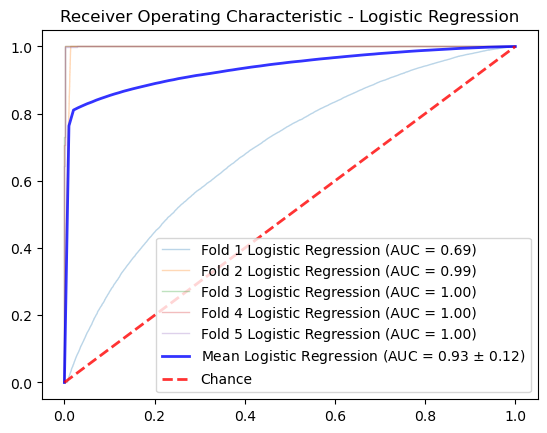

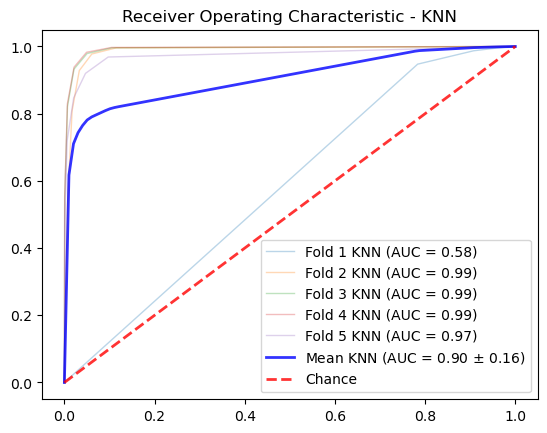

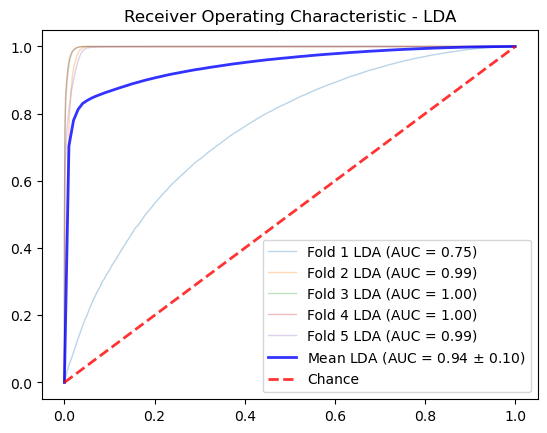

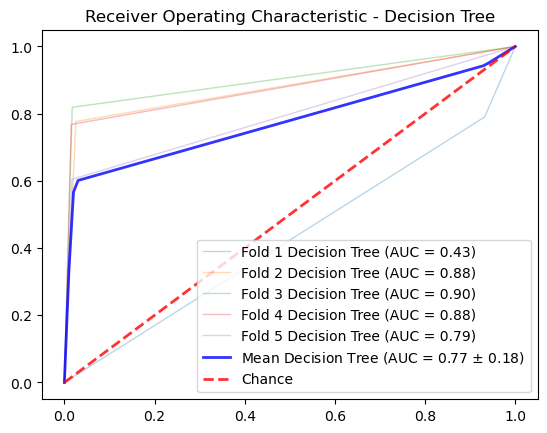

In [22]:
# For Logistic Regression
plot_cv_roc_curve(logistic_classifier, X_train_scaled, y_train, classifier_name='Logistic Regression')

# For KNN
plot_cv_roc_curve(knn_classifier, X_train_scaled, y_train, classifier_name='KNN')

# For LDA
plot_cv_roc_curve(lda_model, X_train_scaled, y_train, classifier_name='LDA')

# For Decision Trees
plot_cv_roc_curve(dt_model, X_train_scaled, y_train, classifier_name='Decision Tree')


### Precision Recall Curve

In [23]:
def plot_cv_precision_recall_curve(classifier, X, y, cv_splits=5, classifier_name='Classifier'):
    """
    Plots Precision-Recall curves for each fold in cross-validation and the mean Precision-Recall curve.
    
    Parameters:
    - classifier: The classifier to use.
    - X: Feature set.
    - y: Target variable.
    - cv_splits: Number of cross-validation splits.
    - classifier_name: Name of the classifier (for legend labeling).
    """
    cv = StratifiedKFold(n_splits=cv_splits)
    mean_recall = np.linspace(0, 1, 100)
    precisions = []
    aucs = []
    fig, ax = plt.subplots()
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        probas_ = classifier.predict_proba(X[test])
        precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1])
        rev_recall = recall[::-1]  # Reverse the recall array
        rev_precision = precision[::-1]  # Reverse the precision array
        precisions.append(np.interp(mean_recall, rev_recall, rev_precision))
        precisions[-1][0] = 1.0
        pr_auc = auc(rev_recall, rev_precision)
        aucs.append(pr_auc)
        ax.plot(recall, precision, lw=1, alpha=0.3, label=f'Fold {i+1} {classifier_name} (AUC = {pr_auc:.2f})')
    
    mean_precision = np.mean(precisions, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    ax.plot(mean_recall, mean_precision, color='b', label=f'Mean {classifier_name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)
    ax.set(xlim=[0, 1.05], ylim=[0, 1.05], title=f"Precision-Recall Curve - {classifier_name}")
    ax.legend(loc="lower left")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()


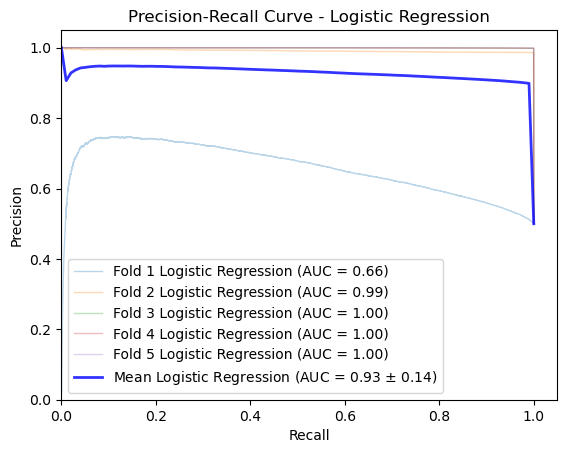

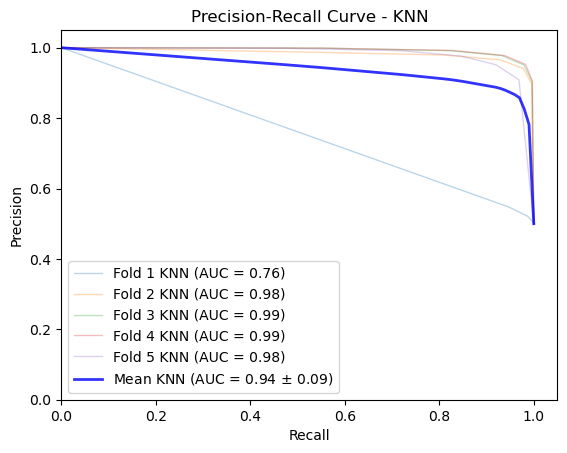

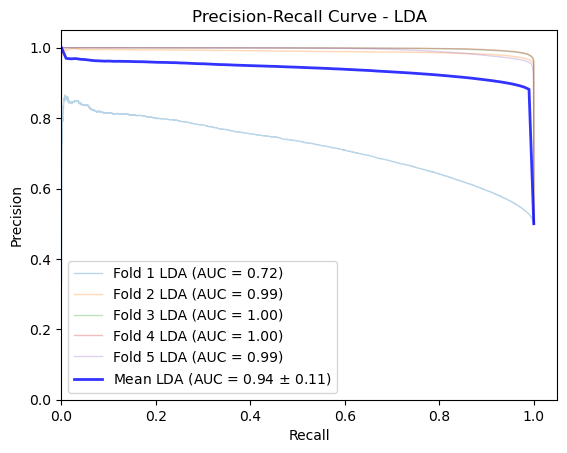

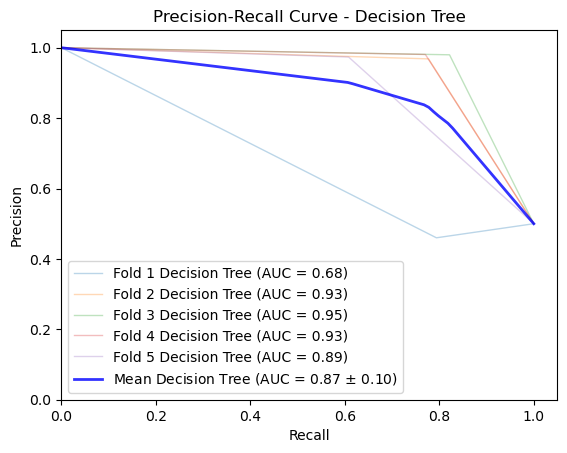

In [24]:
# For Logistic Regression
plot_cv_precision_recall_curve(logistic_classifier, X_train_scaled, y_train, classifier_name='Logistic Regression')

# For KNN
plot_cv_precision_recall_curve(knn_classifier, X_train_scaled, y_train, classifier_name='KNN')

# For LDA
plot_cv_precision_recall_curve(lda_model, X_train_scaled, y_train, classifier_name='LDA')

# For Decision Trees
plot_cv_precision_recall_curve(dt_model, X_train_scaled, y_train, classifier_name='Decision Tree')

## Feature Engineering
### Investigating Features used in the models

- Here is the table summarizing the performance and resource utilization of the models on the **training dataset**:

| Model                | Precision-Recall AUC | ROC AUC | F1 Score | Training Time (seconds) | Peak Memory (MiB) | Memory Increment (MiB) |
|----------------------|----------------------|---------|----------|-------------------------|-------------------|------------------------|
| LDA                  | 0.94                 | 0.776   | 0.901    | 2.781                   | 1236.81           | 732.88                 |
| Decision Tree        | 0.91                 | 0.552   | 0.810    | 16.527                  | 583.27            | 76.55                  |
| Logistic Regression  | 0.94                 | 0.779   | 0.903    | 1.023                   | 824.35            | 147.03                 |
| KNN                  | 0.93                 | 0.694   | 0.895    | 0.094                   | 820.09            | 142.79                 |
- The Precision Recall AUC and F1-score , tells us that all the models are performing well !
- while the models are performing well in terms of Precision-Recall AUC and F1 Score, there are opportunities to further improve their performance and efficiency through careful feature engineering



In [25]:
# Assuming `X_test` and `y_test` are your existing test features and labels
# Split the test set into a smaller test set and a validation set
X_test_smaller, X_validation, y_test_smaller, y_validation = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

Logistic Regression


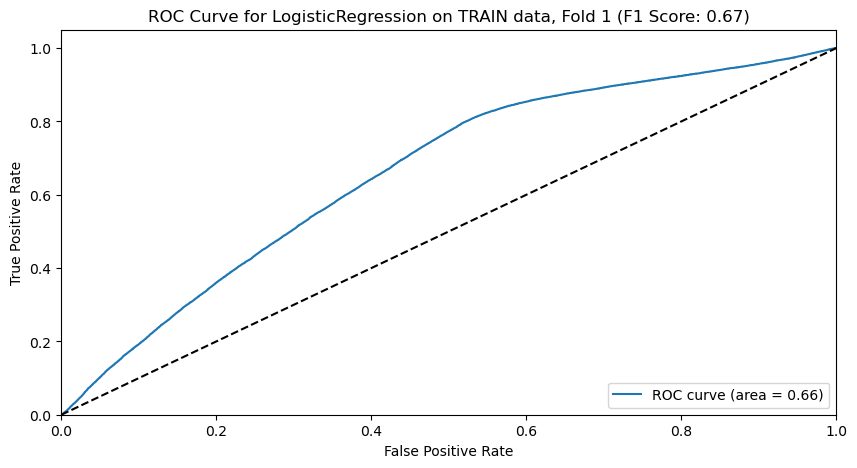

TRAIN DATA, Fold 1
              precision    recall  f1-score   support

           0       0.67      0.52      0.59     39392
           1       0.61      0.75      0.67     39392

    accuracy                           0.63     78784
   macro avg       0.64      0.63      0.63     78784
weighted avg       0.64      0.63      0.63     78784

ROC AUC: 0.66
PR AUC: 0.62
F1 Score: 0.67



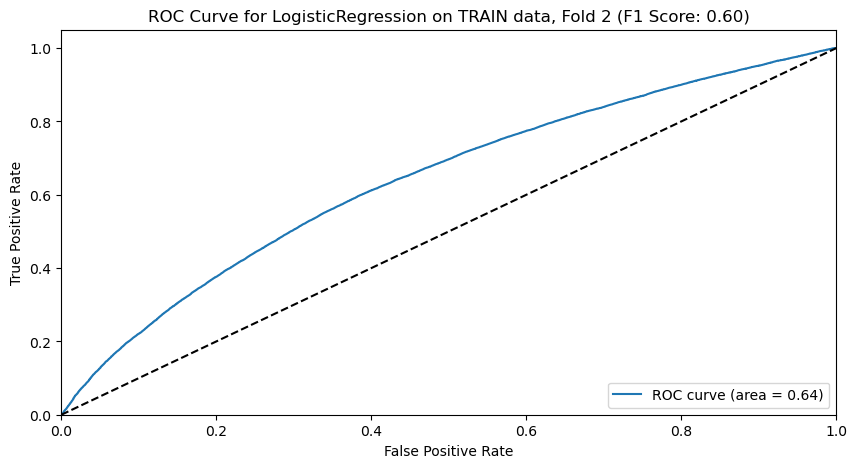

TRAIN DATA, Fold 2
              precision    recall  f1-score   support

           0       0.60      0.62      0.61     39392
           1       0.61      0.60      0.60     39392

    accuracy                           0.61     78784
   macro avg       0.61      0.61      0.61     78784
weighted avg       0.61      0.61      0.61     78784

ROC AUC: 0.64
PR AUC: 0.63
F1 Score: 0.60



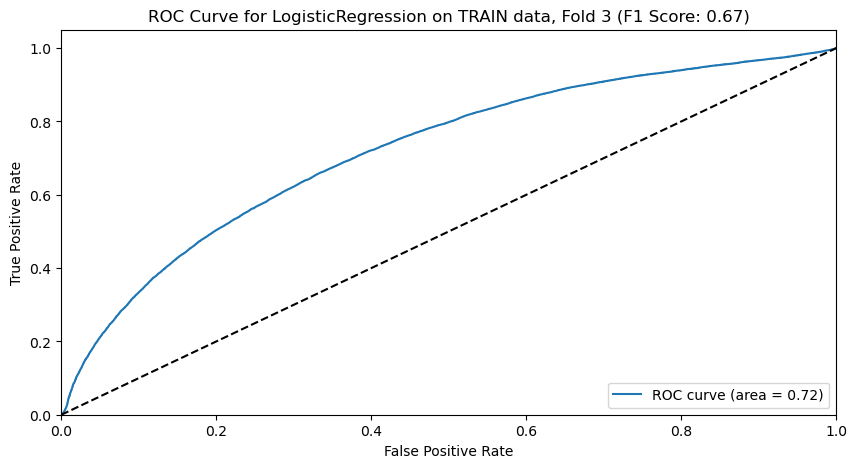

TRAIN DATA, Fold 3
              precision    recall  f1-score   support

           0       0.67      0.64      0.66     39392
           1       0.66      0.68      0.67     39392

    accuracy                           0.66     78784
   macro avg       0.66      0.66      0.66     78784
weighted avg       0.66      0.66      0.66     78784

ROC AUC: 0.72
PR AUC: 0.71
F1 Score: 0.67



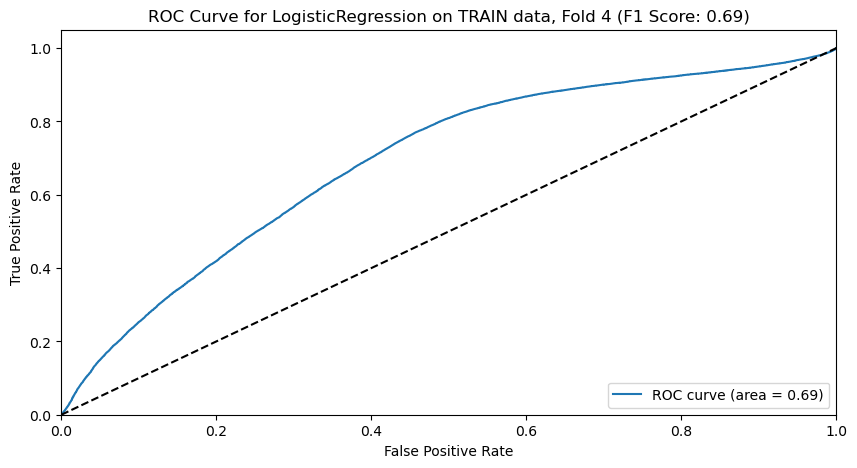

TRAIN DATA, Fold 4
              precision    recall  f1-score   support

           0       0.70      0.55      0.62     39391
           1       0.63      0.76      0.69     39392

    accuracy                           0.66     78783
   macro avg       0.66      0.66      0.65     78783
weighted avg       0.66      0.66      0.65     78783

ROC AUC: 0.69
PR AUC: 0.66
F1 Score: 0.69



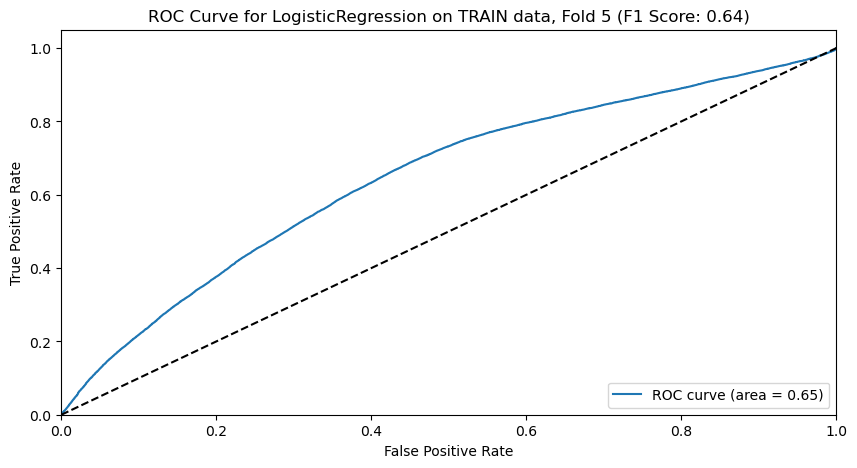

TRAIN DATA, Fold 5
              precision    recall  f1-score   support

           0       0.63      0.56      0.59     39392
           1       0.61      0.68      0.64     39391

    accuracy                           0.62     78783
   macro avg       0.62      0.62      0.62     78783
weighted avg       0.62      0.62      0.62     78783

ROC AUC: 0.65
PR AUC: 0.63
F1 Score: 0.64



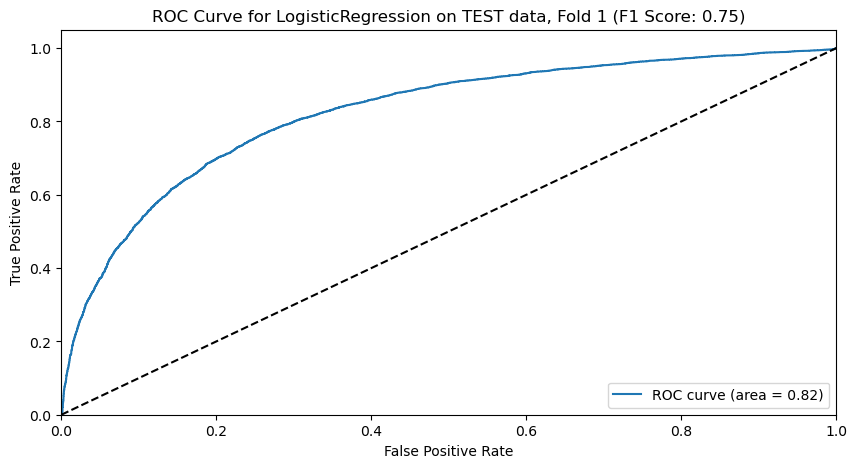

TEST DATA, Fold 1
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75      8056
         1.0       0.75      0.75      0.75      7999

    accuracy                           0.75     16055
   macro avg       0.75      0.75      0.75     16055
weighted avg       0.75      0.75      0.75     16055

ROC AUC: 0.82
PR AUC: 0.82
F1 Score: 0.75



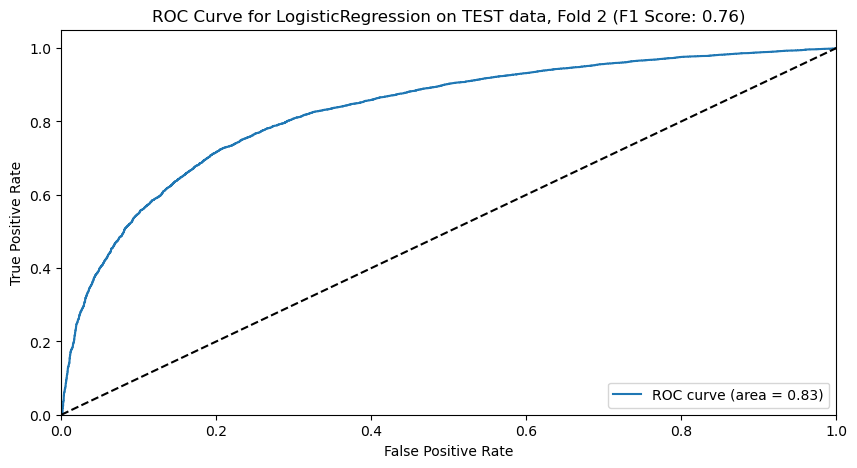

TEST DATA, Fold 2
              precision    recall  f1-score   support

         0.0       0.76      0.75      0.76      8055
         1.0       0.75      0.77      0.76      7999

    accuracy                           0.76     16054
   macro avg       0.76      0.76      0.76     16054
weighted avg       0.76      0.76      0.76     16054

ROC AUC: 0.83
PR AUC: 0.82
F1 Score: 0.76



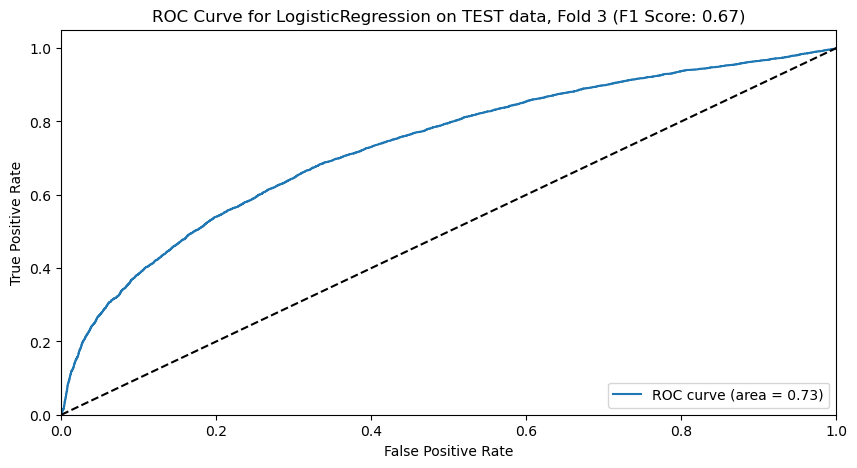

TEST DATA, Fold 3
              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68      8055
         1.0       0.68      0.66      0.67      7999

    accuracy                           0.67     16054
   macro avg       0.67      0.67      0.67     16054
weighted avg       0.67      0.67      0.67     16054

ROC AUC: 0.73
PR AUC: 0.74
F1 Score: 0.67



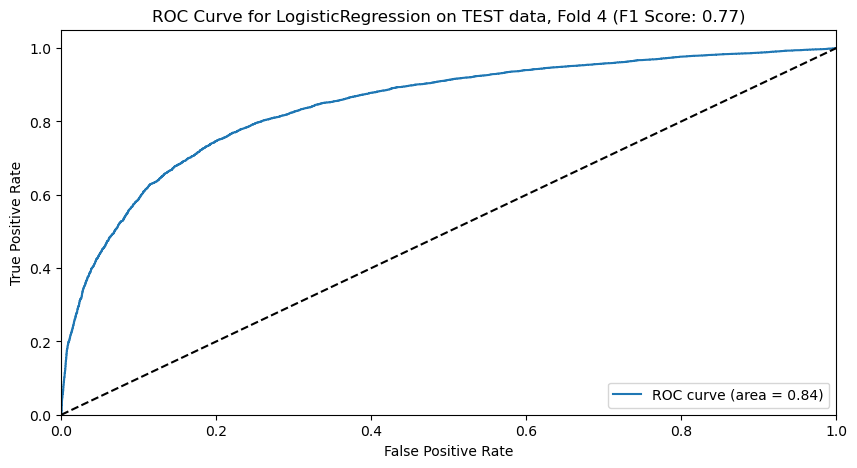

TEST DATA, Fold 4
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77      8055
         1.0       0.76      0.79      0.77      7999

    accuracy                           0.77     16054
   macro avg       0.77      0.77      0.77     16054
weighted avg       0.77      0.77      0.77     16054

ROC AUC: 0.84
PR AUC: 0.85
F1 Score: 0.77



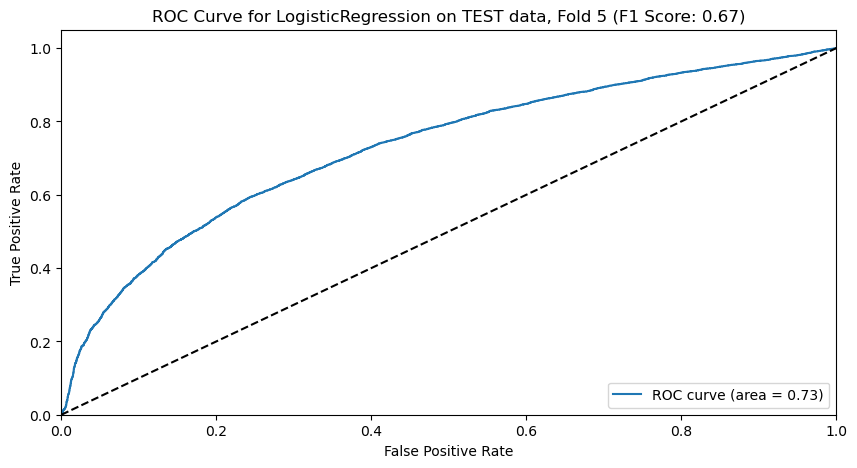

TEST DATA, Fold 5
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      8056
         1.0       0.67      0.66      0.67      7998

    accuracy                           0.67     16054
   macro avg       0.67      0.67      0.67     16054
weighted avg       0.67      0.67      0.67     16054

ROC AUC: 0.73
PR AUC: 0.73
F1 Score: 0.67

KNN


AttributeError: 'Flags' object has no attribute 'c_contiguous'

In [30]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler=None):
    metrics = {}
    model_name = type(model).__name__  # Get the name of the model

    # If a scaler is provided, use it to scale the data
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)  # Note the use of transform here, not fit_transform

    # Initialize StratifiedKFold to preserve the percentage of samples for each class
    cv = StratifiedKFold(n_splits=5)

    for (X, y, data_type) in [(X_train, y_train, 'train'), (X_test, y_test, 'test')]:
        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            # Use .iloc for pandas DataFrame to select data by position
            X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
            X_test_fold, y_test_fold = X.iloc[test_idx], y.iloc[test_idx]

            # Fit the model on the fold's training data
            model.fit(X_train_fold, y_train_fold)
            # Predict on the fold's test data
            y_pred = model.predict(X_test_fold)
            # Get the probability estimates for the positive class
            y_proba = model.predict_proba(X_test_fold)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_fold)
            
            # Calculate metrics
            roc_auc = roc_auc_score(y_test_fold, y_proba)
            f1 = f1_score(y_test_fold, y_pred)
            precision, recall, _ = precision_recall_curve(y_test_fold, y_proba)
            pr_auc = auc(recall, precision)

            # Store metrics
            metrics[f'{data_type}_fold_{fold+1}_roc_auc'] = roc_auc
            metrics[f'{data_type}_fold_{fold+1}_pr_auc'] = pr_auc
            metrics[f'{data_type}_fold_{fold+1}_f1'] = f1

            # Plot ROC Curve for the fold
            fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
            plt.figure(figsize=(10, 5))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {model_name} on {data_type.upper()} data, Fold {fold+1} (F1 Score: {f1:.2f})')
            plt.legend(loc="lower right")
            plt.show()

            print(f"{data_type.upper()} DATA, Fold {fold+1}")
            print(classification_report(y_test_fold, y_pred))
            print(f"ROC AUC: {roc_auc:.2f}")
            print(f"PR AUC: {pr_auc:.2f}")
            print(f"F1 Score: {f1:.2f}\n")

    return metrics

# Evaluate the Logistic Regression model, KNN, LDA and Decision Trees
print("Logistic Regression")
Logistic_model_metrics = evaluate_model(logistic_classifier,X_train,y_train, X_validation, y_validation)
print("KNN")
KNN_model_metrics = evaluate_model(knn_classifier,X_train,y_train, X_validation, y_validation)
print("LDA")
LDA_model_metrics= evaluate_model(lda_model,X_train,y_train, X_validation, y_validation)
print("Decision Trees")
DT_model_metrics= evaluate_model(dt_model,X_train,y_train, X_validation, y_validation)



- Logistic Regression:
  - Relatively low F1 score and ROC AUC indicate that the model might not be capturing the complexity of the data well or could be suffering from the class imbalance.

- KNN:
    - The F1 score is higher compared to Logistic Regression, but the ROC AUC is still low. KNN's performance heavily depends on the feature space and the value of K. It might be getting affected by the high-dimensional space after one-hot encoding.

- LDA:
    - Similar to Logistic Regression, LDA seems to struggle with the dataset's complexity or imbalance, given the low F1 score and ROC AUC.

- Decision Trees:
    - Shows a higher F1 score and the highest ROC AUC among the models, indicating a better fit to the data. 

In [27]:
Corr_Matrix = round(X_train.corr(),2)
print(Corr_Matrix)

                                     fico_range_low  total_acc  pub_rec  \
fico_range_low                                 1.00       0.02    -0.18   
total_acc                                      0.02       1.00     0.02   
pub_rec                                       -0.18       0.02     1.00   
revol_util                                    -0.41      -0.10    -0.09   
annual_inc                                     0.07       0.16    -0.01   
...                                             ...        ...      ...   
verification_status_Not Verified               0.11       0.01    -0.04   
verification_status_Source Verified           -0.10      -0.04     0.03   
verification_status_Verified                  -0.11       0.04     0.03   
initial_list_status_f                         -0.12      -0.02     0.03   
initial_list_status_w                          0.04       0.02    -0.01   

                                     revol_util  annual_inc  int_rate   dti  \
fico_range_low      

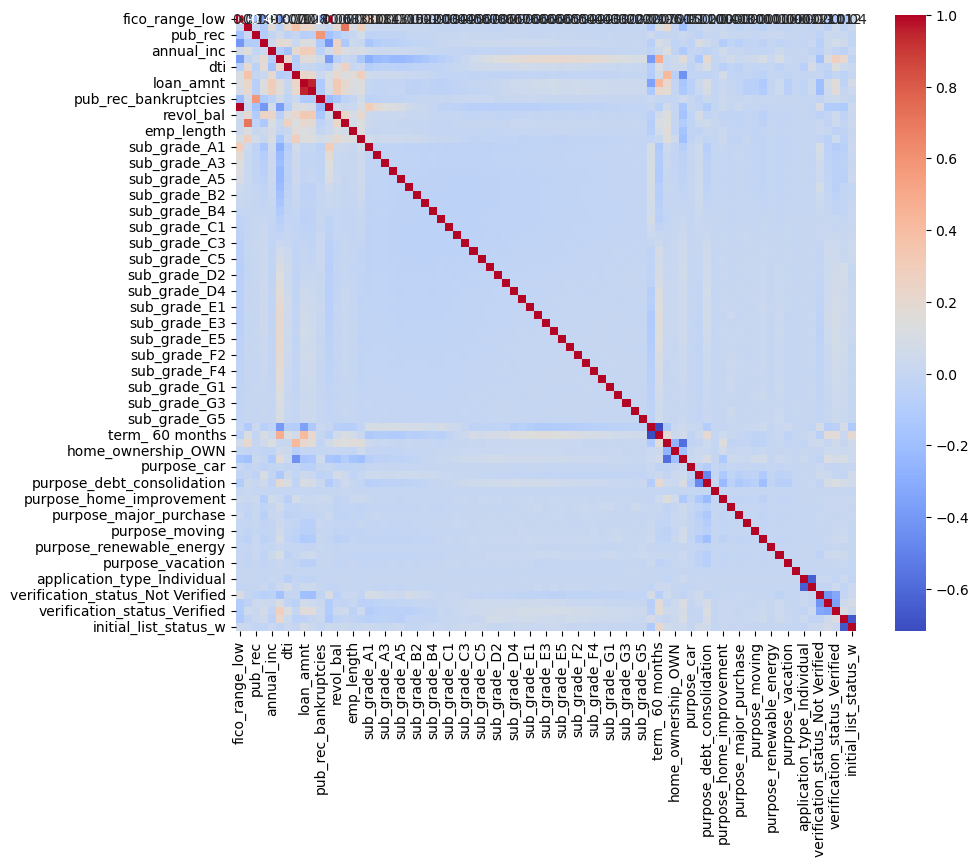

In [28]:
# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

The current co-relation matrix show some level of co-linearity that could be 